In [2]:
!pip install neuralprophet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.6/113.6 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.6/419.6 kB 51.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 65.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.5/187.5 kB 40.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 706.5/706.5 kB 69.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.0/232.0 kB 42.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 76.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 78.0 MB/s eta 0:00:00ta 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 77.0 MB/s eta 0:00:00
  Created wheel for pymeeus: filename=PyMeeus-0.5.11-p

In [36]:
!pip install ipywidgets

In [34]:
!pip install live

  Preparing metadata (setup.py) ... done
  Created wheel for live: filename=live-0.0.3-py3-none-any.whl size=1255 sha256=c1a2c5226236b170e56bc1351e60db088d8487f0dc72a99c293fffd6708befb3
  Stored in directory: /root/.cache/pip/wheels/44/1a/3b/aed1722467ecde71caecb3c7d6a1a6b43842cbc4e1c3d67e99
Successfully built live


In [3]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pandas as pd
from neuralprophet import NeuralProphet


import warnings
import pickle

warnings.filterwarnings('ignore')
path = 'inputs/'
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)
pd.set_option('display.width', 500)
pd.set_option('display.expand_frame_repr', False)


In [4]:
def insert_holidays(testy):
    data = testy.copy()
    data['nat_holiday'] = 0
    data['reg_holiday'] = 0
    data['loc_holiday'] = 0

    stores = stores_new.copy()
    holidays = pd.read_csv(path + 'holidays_events.csv',
                        usecols=['date', 'type', 'locale', 'locale_name', 'transferred'],
                        dtype={'type': 'category', 'locale': 'category', 'locale_name': 'category', 'transferred': 'bool'},
                        parse_dates=['date'], infer_datetime_format=True
                        )
    holidays = holidays.reset_index()
    stores = stores.reset_index()

    for index, row in holidays.iterrows():
        store_nbr_list = []
        if row['locale'] == 'Local':
            for sindex, srow in stores.iterrows():
                if srow['city'] == row['locale_name']:
                    data.loc[(data['date'] == row['date']) & (data['store_nbr'] == srow['store_nbr']), 'loc_holiday'] = 1
        if row['locale'] == 'Regional':
            for sindex, srow in stores.iterrows():
                if srow['state'] == row['locale_name']:
                    data.loc[(data['date'] == row['date']) & (data['store_nbr'] == srow['store_nbr']), 'reg_holiday'] = 1
        if row['locale'] == 'National':
            data.loc[data['date'] == row['date'], 'nat_holiday'] = 1

    return data

In [ ]:
#Adapted from https://www.kaggle.com/code/enesdilsiz/time-series-forecasting-with-lightgbm
def random_noise(dataframe):
    x = np.random.normal(scale=1.5, size=(len(dataframe),))
    return x

# Data preprocessing functions
def lag_features(dataframe, lags, feature):
    for lag in lags:
        dataframe[str(feature) + '_lag_' + str(lag)] = dataframe.groupby(["store_nbr", "family"])[feature].transform(
            lambda x: x.shift(lag))
        #+ random_noise(dataframe)
    return dataframe

def roll_mean_features(dataframe, windows, feature):
    for window in windows:
        dataframe[str(feature) + '_roll_mean_' + str(window)] = dataframe.groupby(["store_nbr", "family"])[feature]. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe


def ewm_features(dataframe, alphas, lags, feature):
    for alpha in alphas:
        for lag in lags:
            dataframe[str(feature) + '_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store_nbr", "family"])[feature].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

def lag_all_features(data, features):
    lags = [x for x in range(1,16)]
    alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
    windows = [128, 365, 546]
    for feature in features:
        data = lag_features(data, lags, feature)
        data = roll_mean_features(data, windows, feature)
        data = ewm_features(data, alphas, lags, feature)
    return data

In [5]:

# Load Oil Data
data_oil = pd.read_csv(path + 'oil.csv', parse_dates=['date'], infer_datetime_format=True)
data_oil['dcoilwtico'].fillna(method='ffill', inplace=True)
data_oil['ma_oil'] = data_oil['dcoilwtico'].rolling(7).mean()
data_oil['ma_oil'].fillna(method='ffill', inplace=True)
calendar = pd.DataFrame()
calendar['date'] = pd.date_range('2013-01-01', '2017-08-31')
cally = pd.merge(calendar, data_oil, how='outer', on='date' )
cally.fillna(method='ffill', inplace=True)
calendar = cally.copy()    #1704 rows

# Load Stores
stores_new = pd.read_csv(path + 'stores.csv',
                         usecols=['store_nbr', 'city', 'state', 'type', 'cluster'],
                         dtype={'store_nbr': 'category', 'city': 'category', 'state': 'category', 'type': 'category', 'cluster': 'category'})

transactions = pd.read_csv(path + 'transactions.csv',
                          usecols=['store_nbr', 'date', 'transactions'],
                          dtype={'store_nbr': 'category', 'transactions': 'float32'},
                          parse_dates=['date'], infer_datetime_format=True)

df_train = pd.read_csv(path + 'train.csv',
                       usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
                       dtype={'store_nbr': 'category', 'family': 'category', 'sales': 'float32', 'onpromotion': 'float32'},
                       parse_dates=['date'], infer_datetime_format=True)

train_oil = pd.merge(df_train, calendar, how='outer', on='date')
train_oil.sort_values(by=['family','store_nbr'], axis=0, inplace=True)
train_oil['ma_oil'].fillna(method='ffill', inplace=True)
train_oil['dcoilwtico'].fillna(method='ffill', inplace=True)
train_oil_trans = pd.merge(transactions, train_oil, how='outer', on =['store_nbr', 'date'])
# train_oil_trans = train_oil_trans[train_oil_trans['family'].notna()]
# tmp.sort_values(by=['store_nbr', 'sales'], axis=0, inplace=True)
# train_oil_trans[train_oil_trans['transactions'].isnull()]
train_oil_trans_stores = train_oil_trans.merge(stores_new, on='store_nbr')
train_oil_trans_stores_holiday = insert_holidays(train_oil_trans_stores)
# tmp = train_oil_trans_stores_holiday[train_oil_trans_stores_holiday.transactions.isnull()]
# tmp = tmp.loc[(tmp.nat_holiday != 1) & (tmp.reg_holiday != 1) & (tmp.loc_holiday != 1)]
# tmp
train_oil_trans_stores_holiday.transactions.fillna(0, inplace=True)
data = train_oil_trans_stores_holiday.copy()
del train_oil_trans_stores_holiday, train_oil_trans_stores, train_oil_trans, train_oil, data_oil, df_train, transactions, cally
data.sort_values(by=['store_nbr', 'family', 'date'], axis=0, inplace=True)


In [38]:
!pip install neuralprophet[live]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 49.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.3/296.3 kB 38.8 MB/s eta 0:00:00


In [41]:
!pip install livelossplot

In [29]:
data['ma_oil'].fillna(method='ffill', inplace=True)
data['dcoilwtico'].fillna(method='ffill', inplace=True)


In [40]:
df = data
stores = data.store_nbr.unique()
families = data.family.unique()
df = df.rename(columns={'date':'ds'})
df = df.rename(columns={'sales':'y'})


m_s = NeuralProphet(
    trend_reg=2,
    yearly_seasonality=True,
    weekly_seasonality=True,
    n_lags=16*7,
    n_forecasts=4,
    num_hidden_layers=5,
    d_hidden=16,
    learning_rate=0.003,)

m_s = m_s.add_lagged_regressor('ma_oil')
m_s = m_s.add_lagged_regressor('dcoilwtico')


for s in stores:
    for f in families:
        df_t = df.loc[(df.store_nbr == s) & (df.family == f)]
        df_train_t, df_test_t = m_s.split_df(df_t[["ds","y","ma_oil","dcoilwtico"]], freq="D", valid_p=0.01)
        metrics = m_s.fit(df_train_t, freq="D", validation_df=df_test_t, plot_live_loss=True)
        with open('models/store"+s+"fam_"+f+".pkl', 'wb') as j:
            pickle.dump(m_s, j)

INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (112)
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (112)
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.703% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.forecaster.__handle_missing_data) - 4 missing dates added.
WARNING - (NP.forecaster.__handle_missing_data) - 4 missing values in column y were detected in total. 
INFO - (NP.forecaster.__handle_missing_data) - 4 NaN values in column y were auto-imputed.
WARNING - (NP.forecaster.__handle_missing_data) - 13 missing values in column ma_oil were detected in total. 
INFO - (NP.forecaster.__handle_missing_data) - 13 NaN values in column ma_

TypeError: fit() got an unexpected keyword argument 'plot_live_loss'

In [ ]:

m_s = NeuralProphet(
    trend_reg=2,
    yearly_seasonality=True,
    weekly_seasonality=True,
    n_lags=16*7,
    n_forecasts=4,
    num_hidden_layers=5,
    d_hidden=16,
    learning_rate=0.003,)

m_s = m_s.add_lagged_regressor('ma_oil')
m_s = m_s.add_lagged_regressor('dcoilwtico')


for s in stores:
    for f in families:
        df_t = df.loc[(df.store_nbr == s) & (df.family == f)]
        df_train_t, df_test_t = m_s.split_df(df_t[["ds","y"]], freq="D", valid_p=0.01)
        metrics = m_s.fit(df_train_t, freq="D", validation_df=df_test_t, plot_live_loss=False)
        with open('models/store"+s+"fam_"+f+".pkl', 'wb') as j:
            pickle.dump(m_s, j)

In [14]:
models = {}
for store in data.store_nbr.unique():
    for fam in data.family.unique():
        model_name = str(store) + "_" + str(fam)
        models[model_name] = pd.DataFrame({'ds': data.loc[(data.store_nbr == store) & (data.family == fam)]['date'], "y": data.loc[(data.store_nbr == store) & (data.family == fam)]['sales']})

models

{'1_AUTOMOTIVE':                ds    y
 110880 2013-01-01  0.0
 55572  2013-01-02  2.0
 55605  2013-01-03  3.0
 55638  2013-01-04  3.0
 55671  2013-01-05  5.0
 ...           ...  ...
 110715 2017-08-11  1.0
 110748 2017-08-12  6.0
 110781 2017-08-13  1.0
 110814 2017-08-14  1.0
 110847 2017-08-15  4.0
 
 [1684 rows x 2 columns],
 '1_BABY CARE':                ds    y
 110881 2013-01-01  0.0
 55573  2013-01-02  0.0
 55606  2013-01-03  0.0
 55639  2013-01-04  0.0
 55672  2013-01-05  0.0
 ...           ...  ...
 110716 2017-08-11  0.0
 110749 2017-08-12  0.0
 110782 2017-08-13  0.0
 110815 2017-08-14  0.0
 110848 2017-08-15  0.0
 
 [1684 rows x 2 columns],
 '1_BEAUTY':                ds    y
 110882 2013-01-01  0.0
 55574  2013-01-02  2.0
 55607  2013-01-03  0.0
 55640  2013-01-04  3.0
 55673  2013-01-05  3.0
 ...           ...  ...
 110717 2017-08-11  1.0
 110750 2017-08-12  3.0
 110783 2017-08-13  1.0
 110816 2017-08-14  6.0
 110849 2017-08-15  4.0
 
 [1684 rows x 2 columns],
 '1_BEVER

In [15]:
df = models["1_AUTOMOTIVE"]
m = NeuralProphet(learning_rate=0.1)
metrics = m.fit(df, freq="D")

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.703% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 166
Missing logger folder: /notebooks/lightning_logs


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.703% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.703% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 53it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.
WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.
WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.


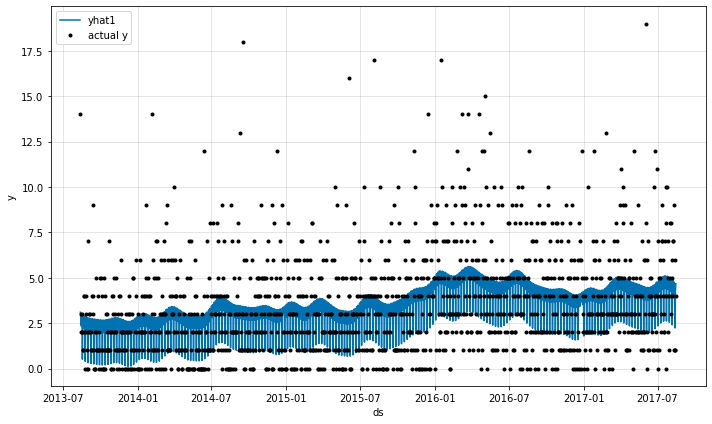

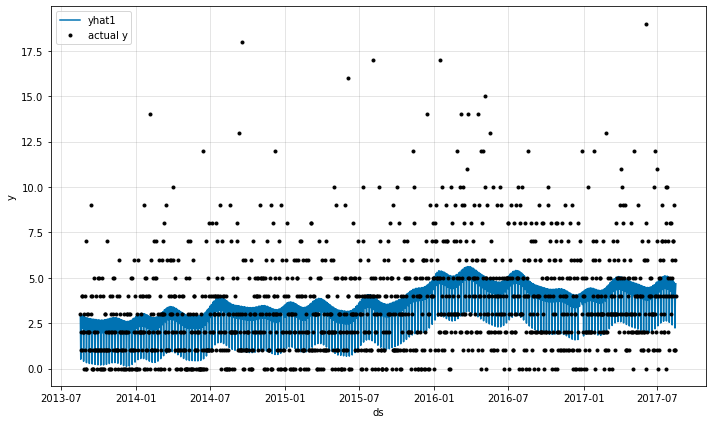

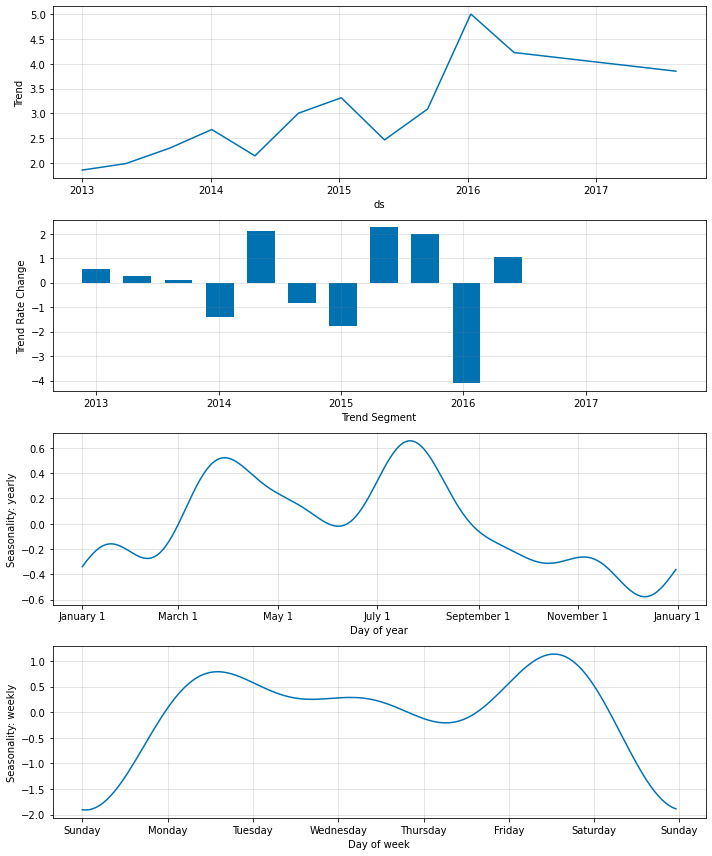

In [17]:
forecast = m.predict(df)
fig1 = m.plot(forecast[-365*4 :])
fig2 = m.plot(forecast[-7*52*4 :])
param = m.plot_parameters()

In [ ]:
feats = ['sales', 'ma_oil', 'dcoilwtico']
data = lag_all_features(data, feats)

# data = roll_mean_features(data, [128, 365, 546])
# data = ewm_features(data, alphas, lags)

In [ ]:
df = data
del data

In [ ]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [ ]:
df['year'] = df.date.dt.year
df['month'] = df.date.dt.month
df['quarter_of_year'] = df.date.dt.quarter
df['week_of_year'] = df.date.dt.isocalendar().week
df['day_of_year'] = df.date.dt.dayofyear
df['day_of_month'] = df.date.dt.day
# df['day_of_week'] = df.date.dt.dayofweek
df["is_wknd"] = df.date.dt.weekday // 4
df['is_month_start'] = df.date.dt.is_month_start.astype(int)
df['is_month_end'] = df.date.dt.is_month_end.astype(int)
df = pd.get_dummies(df, columns=[ 'store_nbr', 'family', 'city', 'state', 'type', 'type', 'cluster'])


In [ ]:
df.info()

In [ ]:
train_df = pd.read_csv(r'm4-weekly-train.csv')
test_df = pd.read_csv(r'm4-weekly-test.csv')
train_df.index = train_df['V1']
train_df = train_df.drop('V1', axis = 1)
test_df.index = test_df['V1']
test_df = test_df.drop('V1', axis = 1)

In [ ]:
test_df.info()

In [ ]:
train = df.loc[(df.date < "2013-07-15"), :]
test_df = df.loc[(df.date >= "2013-07-15" ) & (df.date < "2017-07-31")]

cols = [col for col in train.columns if col not in ['date', 'sales', 'transactions' ]]

train_df = train[cols]

# train_df.index = train_df.sales
# train_df = train_df.drop('sales', axis = 1)
test_df.index = test_df.sales
test_df = test_df.drop('sales', axis = 1)
test_df = test_df.drop('date', axis = 1)

In [ ]:
test_df.iloc[0, :]

In [3]:
#Adapted from https://www.kaggle.com/code/enesdilsiz/time-series-forecasting-with-lightgbm
def random_noise(dataframe):
    x = np.random.normal(scale=1.5, size=(len(dataframe),))
    return x

# Data preprocessing functions
def lag_features(dataframe, lags, feature):
    for lag in lags:
        dataframe[str(feature) + '_lag_' + str(lag)] = dataframe.groupby(["store_nbr", "family"])[feature].transform(
            lambda x: x.shift(lag))
        #+ random_noise(dataframe)
    return dataframe

def roll_mean_features(dataframe, windows, feature):
    for window in windows:
        dataframe[str(feature) + '_roll_mean_' + str(window)] = dataframe.groupby(["store_nbr", "family"])[feature]. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe


def ewm_features(dataframe, alphas, lags, feature):
    for alpha in alphas:
        for lag in lags:
            dataframe[str(feature) + '_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store_nbr", "family"])[feature].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

def lag_all_features(data, features):
    lags = [x for x in range(1,16)]
    alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
    windows = [128, 365, 546]
    for feature in features:
        data = lag_features(data, lags, feature)
        data = roll_mean_features(data, windows, feature)
        data = ewm_features(data, alphas, lags, feature)
    return data

In [4]:

# Load Oil Data
data_oil = pd.read_csv(path + 'oil.csv', parse_dates=['date'], infer_datetime_format=True)
data_oil['dcoilwtico'].fillna(method='ffill', inplace=True)
data_oil['ma_oil'] = data_oil['dcoilwtico'].rolling(7).mean()
data_oil['ma_oil'].fillna(method='ffill', inplace=True)
calendar = pd.DataFrame()
calendar['date'] = pd.date_range('2013-01-01', '2017-08-31')
cally = pd.merge(calendar, data_oil, how='outer', on='date' )
cally.fillna(method='ffill', inplace=True)
calendar = cally.copy()    #1704 rows

# Load Stores
stores_new = pd.read_csv(path + 'stores.csv',
                         usecols=['store_nbr', 'city', 'state', 'type', 'cluster'],
                         dtype={'store_nbr': 'category', 'city': 'category', 'state': 'category', 'type': 'category', 'cluster': 'category'})

transactions = pd.read_csv(path + 'transactions.csv',
                          usecols=['store_nbr', 'date', 'transactions'],
                          dtype={'store_nbr': 'category', 'transactions': 'float32'},
                          parse_dates=['date'], infer_datetime_format=True)

df_train = pd.read_csv(path + 'train.csv',
                       usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
                       dtype={'store_nbr': 'category', 'family': 'category', 'sales': 'float32', 'onpromotion': 'float32'},
                       parse_dates=['date'], infer_datetime_format=True)

train_oil = pd.merge(df_train, calendar, how='outer', on='date')
train_oil.sort_values(by=['family','store_nbr'], axis=0, inplace=True)
train_oil['ma_oil'].fillna(method='ffill', inplace=True)
train_oil['dcoilwtico'].fillna(method='ffill', inplace=True)
train_oil_trans = pd.merge(transactions, train_oil, how='outer', on =['store_nbr', 'date'])
# train_oil_trans = train_oil_trans[train_oil_trans['family'].notna()]
# tmp.sort_values(by=['store_nbr', 'sales'], axis=0, inplace=True)
# train_oil_trans[train_oil_trans['transactions'].isnull()]
train_oil_trans_stores = train_oil_trans.merge(stores_new, on='store_nbr')
train_oil_trans_stores_holiday = insert_holidays(train_oil_trans_stores)
# tmp = train_oil_trans_stores_holiday[train_oil_trans_stores_holiday.transactions.isnull()]
# tmp = tmp.loc[(tmp.nat_holiday != 1) & (tmp.reg_holiday != 1) & (tmp.loc_holiday != 1)]
# tmp
train_oil_trans_stores_holiday.transactions.fillna(0, inplace=True)
data = train_oil_trans_stores_holiday.copy()
del train_oil_trans_stores_holiday, train_oil_trans_stores, train_oil_trans, train_oil, data_oil, df_train, transactions, cally
data.sort_values(by=['store_nbr', 'family', 'date'], axis=0, inplace=True)


In [5]:
feats = ['sales', 'ma_oil', 'dcoilwtico']
data = lag_all_features(data, feats)

# data = roll_mean_features(data, [128, 365, 546])
# data = ewm_features(data, alphas, lags)

In [6]:
df = data
del data

In [7]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [10]:
df['year'] = df.date.dt.year
df['month'] = df.date.dt.month
df['quarter_of_year'] = df.date.dt.quarter
df['week_of_year'] = df.date.dt.isocalendar().week
df['day_of_year'] = df.date.dt.dayofyear
df['day_of_month'] = df.date.dt.day
# df['day_of_week'] = df.date.dt.dayofweek
df["is_wknd"] = df.date.dt.weekday // 4
df['is_month_start'] = df.date.dt.is_month_start.astype(int)
df['is_month_end'] = df.date.dt.is_month_end.astype(int)
df = pd.get_dummies(df, columns=[ 'store_nbr', 'family', 'city', 'state', 'type', 'type', 'cluster'])


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000888 entries, 110880 to 555455
Columns: 449 entries, date to cluster_9
dtypes: UInt32(1), datetime64[ns](1), float32(18), float64(266), int32(2), int64(9), uint8(152)
memory usage: 6.9 GB


In [24]:
train_df = pd.read_csv(r'm4-weekly-train.csv')
test_df = pd.read_csv(r'm4-weekly-test.csv')
train_df.index = train_df['V1']
train_df = train_df.drop('V1', axis = 1)
test_df.index = test_df['V1']
test_df = test_df.drop('V1', axis = 1)

In [26]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 359 entries, W1 to W359
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V2      359 non-null    float64
 1   V3      359 non-null    float64
 2   V4      359 non-null    float64
 3   V5      359 non-null    float64
 4   V6      359 non-null    float64
 5   V7      359 non-null    float64
 6   V8      359 non-null    float64
 7   V9      359 non-null    float64
 8   V10     359 non-null    float64
 9   V11     359 non-null    float64
 10  V12     359 non-null    float64
 11  V13     359 non-null    float64
 12  V14     359 non-null    float64
dtypes: float64(13)
memory usage: 39.3+ KB


In [31]:
train = df.loc[(df.date < "2013-07-15"), :]
test_df = df.loc[(df.date >= "2013-07-15" ) & (df.date < "2017-07-31")]

cols = [col for col in train.columns if col not in ['date', 'sales', 'transactions' ]]

train_df = train[cols]

# train_df.index = train_df.sales
# train_df = train_df.drop('sales', axis = 1)
test_df.index = test_df.sales
test_df = test_df.drop('sales', axis = 1)
test_df = test_df.drop('date', axis = 1)

In [30]:
test_df.iloc[0, :]

date            2013-07-15 00:00:00
transactions                 1781.0
onpromotion                     0.0
dcoilwtico                    106.2
ma_oil                   104.687143
                       ...         
cluster_5                         0
cluster_6                         0
cluster_7                         0
cluster_8                         0
cluster_9                         0
Name: 2.0, Length: 448, dtype: object

In [32]:
smapes = []
naive_smape = []
j = tqdm(range(len(train_df)))
for row in j:
    y = train_df.iloc[row, :].dropna()
    y_test = test_df.iloc[row, :].dropna()
    j.set_description(f'{np.mean(smapes)}, {np.mean(naive_smape)}')
    lp_model = lp.LazyProphet(scale=True,
                           seasonal_period=52,
                           n_basis=10,
                           fourier_order=10,
                           ar=list(range(1, 53)),
                           decay=.99,
                           linear_trend=None,
                           decay_average=False)
    fitted = lp_model.fit(y)
    predictions = lp_model.predict(len(y_test)).reshape(-1)
    smapes.append(smape(y_test.values,      pd.Series(predictions).clip(lower=0)))
    naive_smape.append(smape(y_test.values, np.tile(y.iloc[-1], len(y_test))))
print(np.mean(smapes))
print(np.mean(naive_smape))

nan, nan:   0%|          | 0/347490 [00:00<?, ?it/s]


AttributeError: 'float' object has no attribute 'shape'

In [9]:
train_df = pd.read_csv(r'm4-hourly-train.csv')
test_df = pd.read_csv(r'm4-hourly-test.csv')
train_df.index = train_df['V1']
train_df = train_df.drop('V1', axis = 1)
test_df.index = test_df['V1']
test_df = test_df.drop('V1', axis = 1)
smapes = []
naive_smape = []
j = tqdm(range(len(train_df)))
for row in j:
    y = train_df.iloc[row, :].dropna()
    y_test = test_df.iloc[row, :].dropna()
    j.set_description(f'{np.mean(smapes)}, {np.mean(naive_smape)}')
    lp_model = lp.LazyProphet(seasonal_period=[24,168],
                            n_basis=10,
                            fourier_order=10,
                            ar=list(range(1, 25)),
                            decay=.99)
    fitted = lp_model.fit(y)
    predictions = lp_model.predict(len(y_test)).reshape(-1)
    smapes.append(smape(y_test.values, pd.Series(predictions).clip(lower=0)))
    naive_smape.append(smape(y_test.values, np.tile(y.iloc[-1], len(y_test))))
print(np.mean(smapes))
print(np.mean(naive_smape))

11.630263556364747, 42.86116392273107: 100%|██████████| 414/414 [00:47<00:00,  8.73it/s] 

11.633057576291533
43.002986836424824
